Source:

huggingface: https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews

Tutorial:https://towardsdatascience.com/fine-tuning-hugging-face-model-with-custom-dataset-82b8092f5333

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/sharif/FineTuning/ipython(guide)')

In [3]:
!pip install transformers

     |████████████████████████████████| 1.8MB 8.2MB/s 
     |████████████████████████████████| 2.9MB 36.1MB/s 
     |████████████████████████████████| 890kB 51.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=4c40af1ee80a6fa57368517d175b9d6ccd2b81736ed96850e0f089862edb9248
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
!pip3 install sentencepiece

     |████████████████████████████████| 1.2MB 10.0MB/s 


In [5]:
!git clone https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews
GIT_LFS_SKIP_SMUDGE=1

fatal: destination path 'bert-fa-base-uncased-clf-persiannews' already exists and is not an empty directory.


In [6]:
!pip install -q clean-text[gpl]

     |████████████████████████████████| 133kB 8.2MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
     |████████████████████████████████| 245kB 12.4MB/s 


In [7]:
!pip install -q hazm

     |████████████████████████████████| 317kB 9.4MB/s 
     |████████████████████████████████| 235kB 14.3MB/s 
     |████████████████████████████████| 1.4MB 18.4MB/s 


In [8]:
import torch
import numpy
import pandas
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoConfig,TFAutoModel,AutoModel
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample
from sklearn.metrics import classification_report, accuracy_score

import hazm
from cleantext import clean


In [9]:
# specify GPU
device = torch.device("cuda")

## Data

In [25]:
data = pandas.read_csv('/content/drive/MyDrive/sharif/Spider/Data/unpreprocessed_dataset.csv')

# counter
count_data = data.copy()
count_data = count_data.dropna().reset_index(drop=True)
count = {}
tags_list = pandas.read_excel('../Tags.xlsx',header = None)
tags_list.columns = ['tag']
for _,tag in tags_list.iterrows():
  if tag['tag']!='ویرگول' and tag['tag']!=None and tag['tag']!='':
    count[re.sub(' ','',tag['tag'].lower())] = 0

for indx,d in count_data.iterrows():
  tags = re.sub('\'|\[|\]','',d['tag']).split(',')
  
  for tag in tags:
    if tag.strip().lower() in tags_list.values:
      count[tag.strip().lower().replace(' ','')]+=1 
# count

(array([30., 20., 14.,  7.,  0.,  0.,  2.,  1.,  2.,  2.]),
 array([  34. ,  404.1,  774.2, 1144.3, 1514.4, 1884.5, 2254.6, 2624.7,
        2994.8, 3364.9, 3735. ]),
 <a list of 10 Patch objects>)

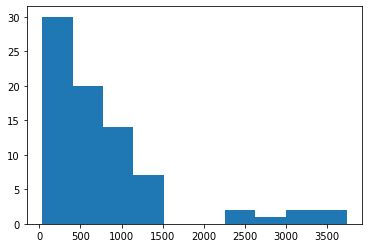

In [12]:
import  matplotlib.pyplot as plt
plt.hist([count[k] for k in list(count.keys())])

In [13]:
limit_number = 1500
limit_number

1500

In [14]:
for i in range(len(data)):

    text=data.loc[i,"body"]
    tags = data.loc[i,'tag']
    data.loc[i,'tag'] = re.sub('ویرگول|c\+\+','',tags.lower())
    tags = re.sub('\[|\]|\'|=|ویرگول',' ',tags)
    tags_list = [t.strip() for t  in tags.split(',') if (t!=' ' and t!='' and (re.sub('[ ]*','',t) in list(count.keys())))]

    # balancing
    if len(tags_list) <1:
      data.loc[i,"body"]=None
      continue
    min_count = min([count[tag.replace(' ','')] for tag in tags_list if (tag.replace(' ','') in list(count.keys()))])

    if min_count<limit_number :

      replications = (limit_number - min_count)//min_count

      d_temp = data.iloc[i,:].copy()
      for _ in range(replications):

        data = data.append(d_temp)
        for tag in tags_list:
          count[tag.replace(' ','')] += 1
    
    for tag in tags_list:
        if count[tag.replace(' ','')]>limit_number:
          for t in tags_list:
            count[t.replace(' ','')] -=1
          data.loc[i,"body"]=None

    if i%500==0:
      print("Record: up to "+str(i)+" from " ,str(len(data)),"is processed.")

Record: up to 0 from  35671 is processed.
Record: up to 500 from  37092 is processed.
Record: up to 1000 from  38099 is processed.
Record: up to 1500 from  38690 is processed.
Record: up to 2000 from  39116 is processed.
Record: up to 2500 from  39514 is processed.
Record: up to 3000 from  39867 is processed.
Record: up to 3500 from  40172 is processed.
Record: up to 4000 from  40519 is processed.
Record: up to 4500 from  40730 is processed.
Record: up to 5000 from  40926 is processed.
Record: up to 5500 from  41121 is processed.
Record: up to 6000 from  41268 is processed.
Record: up to 6500 from  41445 is processed.
Record: up to 7000 from  41578 is processed.
Record: up to 7500 from  41733 is processed.
Record: up to 8000 from  41884 is processed.
Record: up to 8500 from  42062 is processed.
Record: up to 9000 from  42217 is processed.
Record: up to 9500 from  42356 is processed.
Record: up to 10000 from  42502 is processed.
Record: up to 10500 from  42633 is processed.
Record: up t

In [15]:
data = data.dropna().reset_index(drop=True)
data.head()

,body,tag
0,اگر جزو آن دسته دولوپرهایی هستید که پس از چندی...,'' مهارت''
1,دولوپرها همواره به ابزارهای مختلفی نیاز دارند ...,'' کاتلین''
2,چنانچه افرادی را می‌شناسید که جزو توسعه‌دهندگا...,'' برنامه نویسی اندروید''
3,Microsoft Research Open Data یک ریپازیتوری مبت...,'' داده کاوی''
4,امروزه کامپیوترها بخش مهم و بزرگی از زندگی ما ...,'' کامپیوتر''


In [16]:
data.shape

(34536, 2)

In [17]:
# counter 
count_data = data.copy()
count_data = count_data.dropna().reset_index(drop=True)
count = {}
tags_list = pandas.read_excel('../Tags.xlsx',header = None)
tags_list.columns = ['tag']
for _,tag in tags_list.iterrows():
  if tag['tag']!='ویرگول' and tag['tag']!=None and tag['tag']!='':
    count[re.sub(' ','',tag['tag'].lower())] = 0

for indx,d in count_data.iterrows():
  tags = re.sub('\'|\[|\]','',d['tag']).split(',')
  
  for tag in tags:
    if tag.strip().lower() in tags_list.values:
      count[tag.strip().lower().replace(' ','')]+=1 

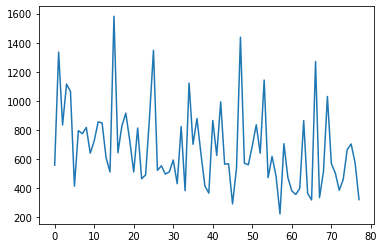

In [ ]:
import matplotlib.pyplot as plt
plt.plot([count[i] for i in list(count.keys())])

In [ ]:
limit_down = int(1500*(3/4))
drop_tags = [i for i in list(count.keys()) if count[i]<limit_down]
len(drop_tags),limit_down

(72, 1125)

In [ ]:
for i in range(len(data)):

    text=data.loc[i,"body"]
    tags = data.loc[i,'tag']
    data.loc[i,'tag'] = re.sub('ویرگول|c\+\+','',tags.lower())
    tags = re.sub('\[|\]|\'|=|ویرگول',' ',tags)
    tags_list = [t.strip() for t  in tags.split(',') if (t!=' ' and t!='' and (re.sub('[ ]*','',t) in list(count.keys())))]
    new_tags = []
    # droping

    for tag in tags_list:
      if tag.replace(' ','') not in drop_tags:
        # print(tag.replace(' ',''))
        new_tags.append(tag)
    if len(new_tags)==0:
      data.loc[i,"body"]=None
      continue
    
    data.loc[i,'tag'] = str(new_tags)
  
    if i%500==0:
      print("Record: up to "+str(i)+" from " ,str(len(data)),"is processed.")

Record: up to 5500 from  34536 is processed.
Record: up to 9500 from  34536 is processed.
Record: up to 10000 from  34536 is processed.
Record: up to 11500 from  34536 is processed.
Record: up to 14000 from  34536 is processed.
Record: up to 14500 from  34536 is processed.
Record: up to 16000 from  34536 is processed.
Record: up to 16500 from  34536 is processed.
Record: up to 17000 from  34536 is processed.
Record: up to 17500 from  34536 is processed.
Record: up to 19000 from  34536 is processed.
Record: up to 22000 from  34536 is processed.
Record: up to 22500 from  34536 is processed.
Record: up to 23000 from  34536 is processed.


In [ ]:
data = data.dropna().reset_index(drop=True)
data.head()

,body,tag
0,Alimama یک پلتفرم دیجیتال مارکتینگ متعلق به کم...,['دیجیتال مارکتینگ']
1,در پاسخ به این سؤال که چرا پایتون محبوب‌ترین ...,['پایتون']
2,زبان برنامه‌نویسی Python به دلیل سینتکس نسبتاً...,['پایتون']
3,تصور کنید به عنوان مدیر یک استارتاپ، مدیر بازا...,['دیجیتال مارکتینگ']
4,مدیران گوگل بر این باورند که وقتی مردم سراسر د...,['دیجیتال مارکتینگ']


In [ ]:
# counter 
count_data = data.copy()
count_data = count_data.dropna().reset_index(drop=True)
count = {}
tags_list = pandas.read_excel('../Tags.xlsx',header = None)
tags_list.columns = ['tag']
for _,tag in tags_list.iterrows():
  if tag['tag']!='ویرگول' and tag['tag']!=None and tag['tag']!='':
    count[re.sub(' ','',tag['tag'].lower())] = 0

for indx,d in count_data.iterrows():
  tags = re.sub('\'|\[|\]','',d['tag']).split(',')
  
  for tag in tags:
    if tag.strip().lower() in tags_list.values:
      count[tag.strip().lower().replace(' ','')]+=1 

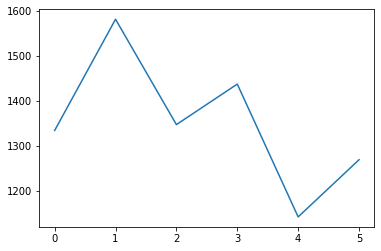

In [ ]:
import matplotlib.pyplot as plt
plt.plot([count[i] for i in list(count.keys()) if count[i]!=0])

In [ ]:
len([[count[i],i] for i in list(count.keys()) if count[i]!=0])

6

In [ ]:
# #All data befor pre-processing...
# print(data['body'])
# print(data.shape)
X = data["body"].values.tolist()
# y = pandas.read_csv('../Data/limited_to_'+str(limit_number)+'.csv')
y=data["tag"].values.tolist()
labels = []
tag=[]
for item in y:
  labels += [i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' ']
  tag.append([i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' '])
labels = list(set(labels))
mlb = MultiLabelBinarizer()
Y=mlb.fit_transform(tag)

In [ ]:
len(labels) , data.shape , len(X) , Y.shape

(6, (7823, 2), 7823, (7823, 6))

In [ ]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [ ]:
# cleaning taxt
clean_x=[]
for t in X:
  clean_x.append(cleaning(t))


In [ ]:
for i in range(10):
  print(clean_x[i])

alimama یک پلتفرم دیجیتال مارکتینگ متعلق به کمپانی alibaba است که به منزلهٔ یک ابزار کپی‌رایتینگ مبتنی بر هوش مصنوعی بوده که با استفاده از مدل‌های یادگیری ژرف و با به‌کارگیری تکنولوژی پردازش زبان طبیعی، اقدام به تولید محتوا برای محصولات مختلف می‌کند. نحوۀ کار ابزار کپی‌رایتر alimamaاین کپی‌رایتر مبتنی بر هوش مصنوعی با آنالیز نمونۀ محتوای سایت‌های تجاری متعلق به کمپانی alibaba (از جمله tmall و taobao) و با استفاده از تکنولوژی یادگیری ژرف، تولید محتوا را یاد می‌گیرد به طوری که توانایی تولید محتوا در حدود ۲۰۰۰۰ خط را در یک ثانیه دارا است و جالب است بدانید که توانسته با موفقیت آزمون تورینگ را پشت سر بگذارد. کاربران به منظور تولید محتوا، بایستی لینکی به صفحه محصول خود را در این سایت وارد کنند و ابزار کپی‌رایتر alimama چندین محتوا را در اختیار ایشان قرار خواهد داد تا محتوای مد نظر خود را انتخاب کنند. همچنین در این پلتفرم امکانی برای کاربران فراهم شده تا بتوانند با انتخاب چند گزینه و بسته به هدف تبلیغاتی‌شان، اندازۀ محتوای خود را تعیین کرده یا حتی روی آن صدایی را تنظیم کنند که این صداها می‌تو

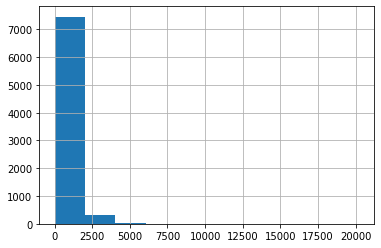

In [ ]:
seq_len = [len(i.split()) for i in clean_x]
pandas.Series(seq_len).hist(bins = 10)

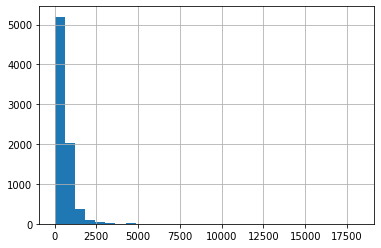

In [ ]:
seq_len = [len([j for j in i.split() if len(j)>2]) for i in X]
pandas.Series(seq_len).hist(bins = 30)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clean_x,Y , test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
print('train: ', len(X_train) , '\ntest: ', len(X_test) , '\nval: ', len(X_val) ,"\ny_tain:",len(y_train) )

train:  4693 
test:  1565 
val:  1565 
y_tain: 4693


In [ ]:
##we would load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")

In [ ]:
#example
text = "ما در هوشواره معتقدیم با انتقال صحیح دانش و آگاهی، همه افراد میتوانند از ابزارهای هوشمند استفاده کنند. شعار ما هوش مصنوعی برای همه است."
tokenized=tokenizer.tokenize(X_train[0])
input_ids = tokenizer.convert_tokens_to_ids(tokenized)
print(tokenized)
print(input_ids)


['برگزاری', 'خوب', 'جلسات', 'هیيت', 'مدیره', '،', 'ترکیب', 'درست', 'اعضا', 'و', 'نحوه', 'پیگیری', 'مصوبات', 'ان', 'از', 'مسايلی', 'است', 'که', 'جامعه', 'استارتاپی', 'ما', 'در', 'رابطه', 'با', 'ان', 'کمتجربه', 'است', 'و', 'این', 'موضوع', 'گاهی', 'چالشهای', 'جدی', 'پیش', 'روی', 'سرمایهگذاران', 'و', 'تیم', 'استارتاپی', 'پدید', 'میاورد', '.', 'انتخاب', 'اعضای', 'هیيت', 'مدیره', 'در', 'جوامع', 'کوچک', 'استارتاپی', 'بعضا', 'ریشه', 'در', 'روابط', 'سهامداران', 'دارد', 'و', 'علاوه', 'بر', 'ان', 'افراد', 'اطلاع', 'درستی', 'از', 'وظایف', 'اعضای', 'هیيت', 'مدیره', 'یا', 'چگونگی', 'پیاده', 'سازی', 'درست', 'نظارت', 'و', 'هدایت', 'بر', 'مدیریت', 'اجرایی', 'شرکت', 'را', 'ندارند', '.', 'در', 'نتیجه', 'هیيت', 'مدیره', '##های', 'شکل', 'گرفته', 'کارامدی', 'لازم', 'را', 'ندارند', '.', 'چیزی', 'که', 'امروز', 'تحت', 'عنوان', 'حاکمیت', 'شرکتی', 'شناخته', 'میشود', 'نیز', 'به', 'دلایلی', 'گره', 'از', 'مشکل', 'شرکتهای', 'کوچک', 'استارتاپی', 'باز', 'نمیکند', 'و', 'الزامات', 'سختگیرانهای', 'را', 'شامل', 'میشود', '

In [ ]:
# encode text
sent_id = tokenizer.batch_encode_plus(X_train[:10], padding=True, return_token_type_ids=False)

In [ ]:
sent_id

{'input_ids': [[2, 5003, 4124, 7295, 5243, 7163, 1348, 4524, 4242, 8449, 1379, 5902, 5960, 11964, 2808, 2791, 10178, 2806, 2800, 3780, 40421, 2964, 2786, 4251, 2799, 2808, 86654, 2806, 1379, 2802, 3444, 4671, 9070, 4851, 2958, 3040, 9168, 1379, 3439, 40421, 4544, 6020, 1012, 3229, 4296, 5243, 7163, 2786, 8388, 3970, 40421, 10619, 5782, 2786, 4311, 8821, 2924, 1379, 3947, 2801, 2808, 3440, 4367, 7201, 2791, 6749, 4296, 5243, 7163, 2880, 7346, 5321, 4434, 4242, 5021, 1379, 5587, 2801, 3916, 4761, 3052, 2803, 4813, 1012, 2786, 3680, 5243, 7163, 2794, 3499, 3296, 15845, 3842, 2803, 4813, 1012, 4082, 2800, 3767, 3671, 3014, 8161, 9719, 4160, 2886, 2921, 2789, 10513, 7864, 2791, 3404, 4125, 3970, 40421, 3012, 5656, 1379, 12277, 40091, 2803, 3581, 2886, 2800, 2831, 4125, 3167, 89583, 1012, 3743, 5165, 2848, 2786, 3102, 6012, 2789, 6564, 3431, 8161, 9719, 2880, 2789, 4881, 5243, 7163, 2786, 4125, 3970, 36439, 1012, 2802, 8699, 13138, 2831, 2988, 10067, 5185, 1379, 4066, 5850, 2806, 1379, 2965,

making dataloader

In [ ]:
# class Pars_bert_Dataset(torch.utils.data.Dataset):
#     """ Create a PyTorch dataset for Taaghche. """

#     def __init__(self, tokenizer, scripts, targets=None, label_list=None, max_len=128):
#         self.scripts = scripts
#         self.targets = targets
#         self.has_target = isinstance(targets, list) or isinstance(targets, numpy.ndarray)

#         self.tokenizer = tokenizer
#         self.max_len = max_len

        
#         self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
#     def __len__(self):
#         return len(self.scripts)

#     def __getitem__(self, item):
#         scripts = str(self.scripts[item])

#         if self.has_target:
#             target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

#         encoding = self.tokenizer.encode_plus(
#             scripts,
#             add_special_tokens=True,
#             truncation=True,
#             max_length=self.max_len,
#             return_token_type_ids=True,
#             padding='max_length',
#             return_attention_mask=True,
#             return_tensors='pt')
        
#         inputs = {
#             'scripts': scripts,
#             'input_ids': encoding['input_ids'].flatten(),
#             'attention_mask': encoding['attention_mask'].flatten(),
#             'token_type_ids': encoding['token_type_ids'].flatten(),
#         }

#         if self.has_target:
#             inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
#         return inputs


# def create_data_loader(X, Y, tokenizer, max_len, batch_size, label_list):
#     dataset = Pars_bert_Dataset(
#         scripts=X,
#         targets=Y,
#         tokenizer=tokenizer,
#         max_len=max_len, 
#         label_list=label_list)
    
#     return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
# max_len = 1400
# batch_size = 32
# train_data_loader = create_data_loader(X_train, y_train, tokenizer, max_len, batch_size, labels)
# valid_data_loader = create_data_loader(X_val, y_val, tokenizer, max_len, batch_size, labels)
# test_data_loader = create_data_loader(X_test, None, tokenizer, max_len, batch_size, labels)

In [ ]:
# sample_test = next(iter(test_data_loader))
# print(sample_test.keys())

In [ ]:
sentence_maxlen=512
# sentence_maxlen=128

In [ ]:
##Tokenize training and validation sentences:
train_encodings = tokenizer.batch_encode_plus(X_train,
    max_length = sentence_maxlen,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
    )

val_encodings = tokenizer.batch_encode_plus(X_val,
    max_length = sentence_maxlen,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
    )

test_encodings=tokenizer.batch_encode_plus(X_test,
    max_length = sentence_maxlen,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
    )

In [ ]:
train_encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
import torch
import torch.nn as nn

# for train set
train_seq = torch.tensor(train_encodings['input_ids'])
train_mask = torch.tensor(train_encodings['attention_mask'])
train_y = torch.FloatTensor(y_train)

# for validation set
val_seq = torch.tensor(val_encodings['input_ids'])
val_mask = torch.tensor(val_encodings['attention_mask'])
val_y = torch.FloatTensor(y_val)

# for test set
test_seq = torch.tensor(test_encodings['input_ids'])
test_mask = torch.tensor(test_encodings['attention_mask'])
test_y = torch.FloatTensor(y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()

In [ ]:
train_y[0]

tensor([1., 0., 0., 0., 0., 0.])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [ ]:
# example


text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
print(sent_id)

seq = torch.tensor(sent_id['input_ids'])
mask = torch.tensor(sent_id['attention_mask'])
train_y = torch.tensor([0,1])

transformer_model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")
cls_hs=transformer_model(seq,mask)
print(cls_hs)
print(cls_hs[0])
print(cls_hs[1])
print(cls_hs[1].shape)
print(cls_hs[0].shape)

{'input_ids': [[2, 32071, 9574, 1026, 89390, 36260, 84378, 40908, 2041, 4, 0], [2, 13632, 25909, 70608, 1011, 40716, 2033, 1026, 89390, 36260, 4]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}
BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0526,  0.5571, -0.4614,  ..., -0.0968,  0.4727,  0.1742],
         [-0.2566,  1.5509, -2.0229,  ..., -1.1688, -0.4160,  0.1496],
         [-0.1851,  0.1336, -1.3189,  ..., -0.5912, -0.4864,  0.4295],
         ...,
         [-0.2249,  0.1459, -1.4157,  ..., -0.1764,  0.6163, -0.5646],
         [-0.3767, -0.2304, -0.3158,  ..., -0.5575,  0.0901,  0.6220],
         [-0.2883,  0.2287, -1.5781,  ..., -0.3559,  0.3813,  0.0665]],

        [[ 0.0939, -0.5881, -1.2552,  ...,  0.9090,  0.5908, -0.1969],
         [-0.2802, -0.9775, -1.5731,  ...,  0.0902,  0.5980, -0.6988],
         [-0.2920, -0.6260, -0.9620,  ..., -0.4935,  0.6855, -1.1112],
         ...,
         [-0.1571, -0.1198, -2

In [ ]:
# model = BERT_Arch(transformer_model)
# model = model.to(device)
# for step,batch in enumerate(train_dataloader):
    
#     # progress update after every 50 batches.
#     if step % 50 == 0 and not step == 0:
#       print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

#     # push the batch to gpu
#     batch = [r.to(device) for r in batch]
#     sent_id, mask, labels = batch
#     preds = model(sent_id,mask)
#     break

In [ ]:
# loss_func=nn.BCELoss(weight=class_weight)
# loss_func = nn.CrossEntropyLoss(weight=class_weight)
# loss=loss_func(preds.float(),labels.float())
    
# loss.backward()

## Model

In [ ]:
transformer_model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")

In [ ]:
# freeze all the parameters
for param in transformer_model.parameters():
    param.requires_grad = False
    

In [ ]:
classnum=len(labels)
classnum

6

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      self.bn_0 = nn.BatchNorm1d(768)

      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      # self.relu =  nn.ReLU()
      self.elu =  nn.ELU()

      self.tanh=nn.Tanh()


      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      self.bn_1 = nn.BatchNorm1d(512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,classnum)

      self.bn_2 = nn.BatchNorm1d(classnum)

      #sigmoid activation function
      self.sigmoid = nn.Sigmoid()

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.bn_0(cls_hs[1])

      x = self.fc1(x)
      
      x = self.bn_1(x)
      
      x = self.elu(x)

      x = self.dropout(x)

      x = self.fc2(x)

      x = self.bn_2(x)
      # print("after fc2:",x)
      # apply sigmoid activation
      x = self.sigmoid(x)
      # print("after fc2 sigmoid:",x)
      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(transformer_model)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW


# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)

In [ ]:
##Calculating weights 
class_counts=[0]*classnum
for cl in Y:
    #  print(cl)
     for i in range(classnum):
      #  print(i)
       if cl[i]==1:
          class_counts[i]+=1
print(class_counts)

weight=[]
for indx in range(classnum):
  weight.append(((class_counts[indx]/len(Y))))

print(weight)

# class_weight= torch.tensor(weight,dtype=torch.float)
class_weight = torch.FloatTensor(weight)
class_weight = class_weight.to(device)
print(class_weight)

[1582, 1143, 1438, 1335, 1270, 1348]
[0.2022242106608718, 0.14610763134347438, 0.18381695001917422, 0.17065064553240444, 0.1623418126038604, 0.17231241211811327]
tensor([0.2022, 0.1461, 0.1838, 0.1707, 0.1623, 0.1723], device='cuda:0')


In [ ]:
# loss_func =nn.MultiLabelMarginLoss()
# loss_func=nn.BCEWithLogitsLoss(weight=class_weight)
loss_func=nn.BCELoss(weight=class_weight)
# loss_func = nn.CrossEntropyLoss(weight=class_weight)
# loss_func=nn.NLLLoss(weight=class_weight)

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch
   
    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    
    # compute the loss between actual and predicted values
    loss=loss_func(preds,labels)
    
    # loss=0
      
    # for b in range(batch_size):
    #   for l in range(classnum):
    #     print(preds[b][l], labels[b][l])
    #     loss += loss_func(preds[b][l], labels[b][l])

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch
    

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)
      
      # compute the validation loss between actual and predicted values

      # loss=0
      # for b in range(batch_size):
      #   for l in range(classnum):
      #     loss += loss_func(preds[b][l], labels[b][l])
      
      loss=loss_func(preds,labels)
      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# number of training epochs
epochs = 30

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 30
  Batch    50  of    147.
  Batch   100  of    147.

Evaluating...

Training Loss: 0.104
Validation Loss: 0.095

 Epoch 2 / 30
  Batch    50  of    147.
  Batch   100  of    147.

Evaluating...

Training Loss: 0.093
Validation Loss: 0.087

 Epoch 3 / 30
  Batch    50  of    147.
  Batch   100  of    147.

Evaluating...

Training Loss: 0.086
Validation Loss: 0.080

 Epoch 4 / 30
  Batch    50  of    147.
  Batch   100  of    147.

Evaluating...

Training Loss: 0.080
Validation Loss: 0.075

 Epoch 5 / 30
  Batch    50  of    147.
  Batch   100  of    147.

Evaluating...

Training Loss: 0.075
Validation Loss: 0.071

 Epoch 6 / 30
  Batch    50  of    147.
  Batch   100  of    147.

Evaluating...

Training Loss: 0.071
Validation Loss: 0.067

 Epoch 7 / 30
  Batch    50  of    147.
  Batch   100  of    147.

Evaluating...

Training Loss: 0.068
Validation Loss: 0.065

 Epoch 8 / 30
  Batch    50  of    147.
  Batch   100  of    147.

Evaluating...

Training Loss: 0.065
Validat

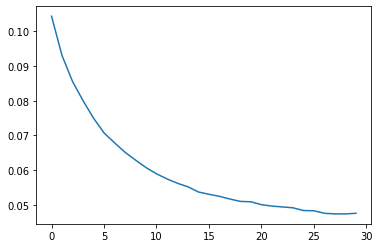

In [ ]:
plt.plot(train_losses)

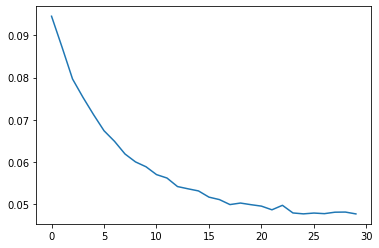

In [ ]:
plt.plot(valid_losses)

Loading saved model:

In [ ]:
torch.save(model.state_dict(), 'ParsBERT_pytorch_weighted_0_750.pt')

# # torch.cuda.empty_cache()
# # pass the pre-trained BERT to our define architecture
# model = BERT_Arch(transformer_model)

# # push the model to GPU
# model = model.to(device)

In [ ]:
# #load weights of best model
# path = 'saved_weights.pt'
# model.load_state_dict(torch.load(path))

In [ ]:
for param in model.parameters():
  print(param)

Streaming output truncated to the last 5000 lines.
        -1.6285e-01,  1.3620e-01, -5.6054e-02,  6.3577e-02,  6.0674e-02,
        -7.6196e-02,  4.7786e-02,  1.7381e-02, -3.5285e-02, -6.7078e-02,
         6.7528e-02, -7.3692e-02,  5.0126e-04,  3.2402e-02, -7.6729e-03,
        -1.6317e-02,  3.1190e-02, -3.0267e-02, -1.8601e-03,  7.0489e-02,
        -6.4617e-02,  3.5394e-02,  1.4462e-02, -6.3424e-02, -8.9265e-03,
        -8.9561e-02,  2.6663e-02,  4.8810e-02,  1.9307e-02, -1.7272e-02,
        -4.1383e-02,  1.0834e-01, -3.4801e-02,  1.1548e-01,  9.6698e-03,
        -1.1403e-01, -6.5185e-02, -2.5738e-02, -4.7346e-02, -1.1859e-01,
         8.7365e-03,  2.6555e-02, -8.5731e-02,  9.5921e-02,  9.5436e-03,
         4.9453e-02,  8.9601e-03,  3.2050e-02, -7.0203e-02,  6.0052e-02,
        -2.2199e-02, -9.8855e-02,  3.3565e-03,  3.7472e-02, -3.5911e-02,
         4.7546e-02, -1.0503e-01,  2.4618e-02, -2.1746e-02,  6.5412e-02,
         1.0142e-02,  5.6304e-02,  2.8553e-02,  3.7031e-03,  1.1479e-02,


After loading model:

In [ ]:
y_pred=[]
y_true=[]
for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      # outputs_before_sigmoid = model(sent_id, mask)
      preds = model(sent_id, mask)
      # print(preds)
      # print(preds.cpu().numpy())
      
      
      # outputs_before_sigmoid = outputs_before_sigmoid.cpu().numpy()
      # model's performance
    # preds = numpy.argmax(preds, axis = 1)
    # print(len(preds),len(preds[0]))
    # measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    # print(measure)


    # preds=[]
    # for l in range(len(outputs_before_sigmoid)):
    #   preds.append(torch.sigmoid(outputs_before_sigmoid[l]))
    # preds = preds.cpu().numpy()
    # print(preds)
    # measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    # for l in range(len(outputs_before_sigmoid)):
    #   temp=[]
    #   for value in preds:
    #     if value >= measure:
    #       temp.append(1)
          
    #     else:
    #       temp.append(0)
    #   y_pred.append(temp)
    #   y_true.append(labels.cpu().numpy()[l])
    #   # print( preds[l])
    #   print("temp:",(temp))
    #   print("labels:",labels.cpu().numpy()[l])
    
    # print(labels.cpu().numpy()[0], preds[0])
  

    # for l in range(len(preds)):
    #   preds.append(torch.sigmoid(outputs_before_sigmoid[l]))
    # preds = preds.cpu().numpy()
    # print(preds)
    preds = preds.cpu().numpy()
    measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    for l in range(len(preds)):
      temp=[]
      for value in preds[l]:
        if value >= measure:
          temp.append(1)
          
        else:
          temp.append(0)
      y_pred.append(temp)
      y_true.append(labels.cpu().numpy()[l])
      # print( preds[l])
      # print("temp:",(temp))
      # print("labels:",labels.cpu().numpy()[l])

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.51      0.54       306
           1       0.68      0.62      0.65       233
           2       0.63      0.57      0.60       278
           3       0.96      0.81      0.88       257
           4       0.80      0.61      0.69       260
           5       0.46      0.15      0.23       294

   micro avg       0.70      0.53      0.61      1628
   macro avg       0.69      0.55      0.60      1628
weighted avg       0.68      0.53      0.59      1628
 samples avg       0.52      0.55      0.53      1628



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
